<h1>SVHN Image Classification using Neural Network </h1>

<h2> Overview </h2>

Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of such street-level photographs is Google’s Street View imagery comprised of hundreds of millions of geo-located 360-degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents.Recognizing numbers in photographs through OCR is limited due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and character arrangements. The recognition problem is further complicated by environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs.  

<h2> Objective </h2>

The objective of the project is to learn how to implement a simple image classification pipeline based on a deep neural network and understand the basics of Image Classification.

The goals of this project are as follows:

1. Read the data from the h5py file and understand the train/test splits
2. Reshape and normalize the train and test features
3. One hot encode the labels for train and test data
4. Define the model architecture using TensorFlow with a flatten layer followed by dense layers with activation as ReLu and softmax
5. Compile the model with loss as categorical cross-entropy and adam optimizers. Use accuracy as the metric for evaluation
6. Fit and evaluate the model. Print the loss and accuracy for the test data

<h2> Project Implementation </h2>

<h3> Import Required Libraries </h3>

In [174]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import random
import h5py
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Disable warnings
logging.disable(logging.WARNING) 
# Set random seed
random.seed(1)                   
# Draw Plots Inline
%matplotlib inline               

<h2> 1. Read the data from the h5py file and understand the train/test splits </h2>

<h3> Load the dataset </h3>

In [175]:
#Open the file as read-only
h5f = h5py.File('SVHN_single_grey1.h5', 'r')

In [176]:
#Load the training and test data
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

<h3> Understand the Train / Test Splits </h3>

In [177]:
X_train.shape

(42000, 32, 32)

<h4> The training dataset contains 42k images with 32 x 32 pixels each </h4>

In [178]:
y_train.shape

(42000,)

<h4> The training dataset also contains 42k labels with proper classification for the images </h4>

In [179]:
X_test.shape

(18000, 32, 32)

<h4> The test dataset contains 18k images with 32 x 32 pixels each </h4>

In [180]:
y_test.shape

(18000,)

<h4> The test dataset contains 18k labels with proper classification for the images </h4>

In [181]:
X_Orig_train=X_train
X_Orig_test=X_test

<h3> Display the first 25 images of the dataset </h3>

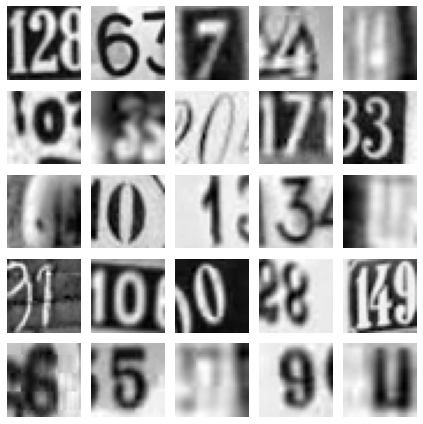

In [182]:
#set the size of the plot
plt.figure(figsize=(6,6))

for index in range(25):
  plt.subplot(5,5, index+1)
  plt.imshow(X_Orig_train[index], cmap='gray')
  plt.axis('off')

plt.tight_layout()

<h3> Display the first 25 labels for the above images of the dataset </h3>

In [183]:
y_train[0:25]

array([2, 6, 7, 4, 4, 0, 3, 0, 7, 3, 1, 0, 1, 3, 1, 1, 0, 0, 8, 4, 6, 5,
       7, 9, 1], dtype=uint8)

<h4> From the above when we compare the images with their respective classes we observe that while some Images are blurred other images have multiple digits in them and there is no consistency in the way the digits appear in different images
</h4>

<h2> 2. Reshape and Normalize the Train and Test features </h2>

<h3> Print shape of the data </h3>

In [122]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42000, 32, 32)
(42000,)
(18000, 32, 32)
(18000,)


<h3> Reshape train and test sets into compatible shapes </h3>

- Sequential model in tensorflow.keras expects data to be in the format (n_e, n_h, n_w, n_c)
- n_e= number of examples, n_h = height, n_w = width, n_c = number of channels
- In this case, we will flatten the images on both training and test to 1024 as the image size is 32*32

In [123]:
X_train = X_train.reshape(X_train.shape[0], 1024).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1024).astype('float32')

In [124]:
X_train.shape

(42000, 1024)

In [125]:
X_test.shape

(18000, 1024)

<h3> Normalize the data </h3>

- we must normalize our data as it is always required in neural network models
- we can achieve this by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)
- normalize X_train and X_test
- make sure that the values are float so that we can get decimal points after division

In [126]:
X_train /= 255
X_test /= 255

<h3> Print shape of data and number of images </h3>

- print shape of X_train
- print number of images in X_train
- print number of images in X_test

In [127]:
print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test:", X_test.shape[0])
print("Max value in X_train:", X_train.max())
print("Min value in X_train:", X_train.min())

X_train shape: (42000, 1024)
Images in X_train: 42000
Images in X_test: 18000
Max value in X_train: 0.9999
Min value in X_train: 0.0


In [128]:
#Verify that data of the first image in the training and test dataset
print (X_train[0])
print (X_test[0])

[0.12968785 0.11866706 0.10530196 ... 0.19477727 0.19942354 0.20799099]
[0.15905097 0.18349686 0.19206432 ... 0.43143883 0.4360851  0.44780627]


<h2> 3. One hot encoding of Labels for Train and Test data </h2>

The output of the network needs to classify the images between 0 to 9 i.e there are 10 classes. The loss function used in our neural network will be cross entropy which expects the data in one hot encoding.

So we,
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 10
- we are doing this to use categorical_crossentropy as loss

In [129]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Shape of y_train:", y_train.shape)
print("One value of y_train:", y_train[0])

Shape of y_train: (42000, 10)
One value of y_train: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


<h2> 4. Neural Network architecture with SGD optimization </h2>

The neural network architecture design will have the following propoerties

**Input Layer :**
- No. of neurons : **1024**

**Hidden Layer 1 :**
- No. of neurons : **64**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Hidden Layer 2 :**
- No. of neurons : **64**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Hidden Layer 3 :**
- No. of neurons : **32**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**
- Dropout : **0.3**

**Output Layer :**
- No. of neurons : **10**
- Activation Function : **Softmax**

**Additional properties of neural network**
- Optimizer : **SGD**
- Learning rate : **0.01**
- Loss Function : **Cross Entropy**
- Batch Size : **60**
- Epoch : **25**

<h3> Define the Neural Network architecture </h3>

In [23]:
svhn_model = Sequential()
#First Hidden Layer
svhn_model.add(Dense(64, activation='relu', input_shape=(1024,)))

#Add batch normalization
svhn_model.add(BatchNormalization())

#Second Hidden Layer
svhn_model.add(Dense(64, activation='relu'))

#Add batch normalization
svhn_model.add(BatchNormalization())

# Third Hidden Layer
svhn_model.add(Dense(32, activation='relu'))

#Add batch normalization
svhn_model.add(BatchNormalization())

# Add dropout of 30% for regularization
svhn_model.add(Dropout(0.3))

#Output layer
svhn_model.add(Dense(10, activation='softmax'))

<h3> Model Summary </h3>

In [24]:
svhn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)               

<h3> Compile the Model </h3>

In [130]:
# The model will use SGD as optimizer with learning rate of 0.01 and cross entropy as loss function
svhn_model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

<h3> Define output path for logs and callbacks </h3>

In [132]:
output_dir = 'Model_Output/'

In [133]:
run_name = 'regression_baseline'
output_path = output_dir + run_name

In [134]:
#Define a model checkpoint callback which will be used to save weights for each spoch
modelcheckpoint = ModelCheckpoint(output_path + '/weights.{epoch:02d}.hdf5', save_weights_only=True)

In [135]:
# If the directory does not exist, create the directory
if not os.path.exists(output_path):
   os.makedirs(output_path)

In [136]:
#Define tensorboard log file
tensorboard = TensorBoard(log_dir='logs/' + run_name)

<h3> Train the model </h3>

In [138]:
# Train the model with batch size of 60 (which means each batch will have 700 images) and epoch of 25. 
svhn_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=60, epochs=25, verbose=1)

Epoch 1/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.8002 - val_loss: 0.6633 - val_accuracy: 0.8006
Epoch 2/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6550 - accuracy: 0.8015 - val_loss: 0.7178 - val_accuracy: 0.7799
Epoch 3/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6529 - accuracy: 0.8036 - val_loss: 0.6739 - val_accuracy: 0.7940
Epoch 4/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6500 - accuracy: 0.8023 - val_loss: 0.7506 - val_accuracy: 0.7682
Epoch 5/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6476 - accuracy: 0.8019 - val_loss: 0.6180 - val_accuracy: 0.8133
Epoch 6/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6525 - accuracy: 0.8034 - val_loss: 0.6613 - val_accuracy: 0.7961
Epoch 7/25
700/700 [==============================] - 1s 2ms/step - loss: 0.6488 - accuracy: 0.8023 - val_loss: 0.6210 - val_accuracy: 0.8117
Epoch 

<h4> The best performance of our model is on epoch 11 with validation accuracy of ~82%. We will change some aspects of our model architecture to see if we can increase the accuracy. </h4>

<h2>5. Neural Network architecture with Adam optimization </h2>

We will fine tune the architecture by making the following changes to the architecture

1) One additional hidden layer

2) Increase the number of neurons to 128 in first hidden layer

3) Optimizer = 'nadam'

4) Batch Size = 40

The neural network architecture design will have the following propoerties

**Input Layer :**
- No. of neurons : 1024

**Hidden Layer 1 :**
- No. of neurons : **128**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Hidden Layer 2 :**
- No. of neurons : **64**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Hidden Layer 3 :**
- No. of neurons : **64**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Hidden Layer 4 :**
- No. of neurons : **32**
- Activation Function : **ReLU**
- Batch Normalization : **Yes**

**Output Layer :**
- No. of neurons : **10**
- Activation Function : **Softmax**

**Additional properties of neural network**
- Optimizer : **nadam**
- Learning rate : **0.01**
- Loss Function : **Cross Entropy**
- Batch Size : **40**
- Epoch : **25**

<h3> Define the Neural Network architecture with Additional Layer </h3>

In [29]:
svhn1_model = Sequential()

#First Hidden Layer
svhn1_model.add(Dense(128, activation='relu', input_shape=(1024,)))

#Add batch normalization
svhn1_model.add(BatchNormalization())

#Second Hidden Layer
svhn1_model.add(Dense(64, activation='relu'))

#Add batch normalization
svhn1_model.add(BatchNormalization())

# Third Hidden Layer
svhn1_model.add(Dense(64, activation='relu'))

#Add batch normalization
svhn1_model.add(BatchNormalization())

# Fourth Hidden Layer
svhn1_model.add(Dense(32, activation='relu'))

#Add batch normalization
svhn1_model.add(BatchNormalization())

# Add dropout of 30% for regularization
svhn1_model.add(Dropout(0.3))

#Output layer
svhn1_model.add(Dense(10, activation='softmax'))

In [30]:
svhn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

<h3> Compile the Model with Adam Optimization and Additional Layer</h3>

In [140]:
svhn1_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

<h3> Change the path of logs and create directory </h3>

In [167]:
run_name = 'regression_Nadam'
output_path = output_dir + run_name

In [168]:
# If the directory does not exist, create the directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [169]:
#Define a model checkpoint callback which will be used to save weights for each spoch
modelcheckpoint = ModelCheckpoint(output_path + '/weights.{epoch:02d}.hdf5', save_weights_only=True)

In [170]:
#Define tensorboard log file
tensorboard = TensorBoard(log_dir='logs/' + run_name)

<h3> Train the model with Adam Optimization </h3>

In [171]:
# Train the model with batch size of 40 (which means each batch will have 1050 images) and epoch of 25. 
svhn1_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=40, epochs=25, verbose=1)

Epoch 1/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5882 - accuracy: 0.8190 - val_loss: 0.6742 - val_accuracy: 0.7988
Epoch 2/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5855 - accuracy: 0.8180 - val_loss: 0.5950 - val_accuracy: 0.8213
Epoch 3/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5839 - accuracy: 0.8186 - val_loss: 0.6505 - val_accuracy: 0.8055
Epoch 4/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5809 - accuracy: 0.8200 - val_loss: 0.6229 - val_accuracy: 0.8113
Epoch 5/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5863 - accuracy: 0.8200 - val_loss: 0.6106 - val_accuracy: 0.8185
Epoch 6/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5838 - accuracy: 0.8192 - val_loss: 0.6440 - val_accuracy: 0.8047
Epoch 7/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5849 - accuracy: 0.8198 - val_loss: 0.6454 - val_accuracy:

<h4> The best validation accuracy that we achieved was on epoch 19 where the accuracy was ~82%. </h4>

<h2> 6. Visualizing some predictions </h2>

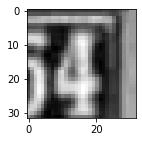

Label for the above image:  4
Predicted label for above image using SGD Optimization:  [4]
Predicted label for above image using Adam Optimization:  [4]


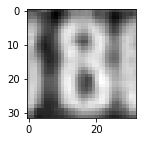

Label for the above image:  8
Predicted label for above image using SGD Optimization:  [8]
Predicted label for above image using Adam Optimization:  [4]


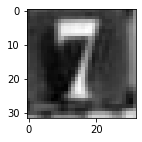

Label for the above image:  7
Predicted label for above image using SGD Optimization:  [0]
Predicted label for above image using Adam Optimization:  [7]


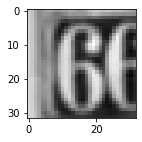

Label for the above image:  6
Predicted label for above image using SGD Optimization:  [6]
Predicted label for above image using Adam Optimization:  [6]


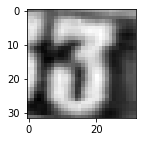

Label for the above image:  3
Predicted label for above image using SGD Optimization:  [3]
Predicted label for above image using Adam Optimization:  [3]


In [184]:
plt.figure(figsize=(2,2))
plt.imshow(X_Orig_test[13], cmap="gray")
plt.show()

print("Label for the above image: ", y_test[13])
print("Predicted label for above image using SGD Optimization: ", svhn_model.predict_classes(X_Orig_test[13].reshape(1,1024)))
print("Predicted label for above image using Adam Optimization: ", svhn1_model.predict_classes(X_Orig_test[13].reshape(1,1024)))


plt.figure(figsize=(2,2))
plt.imshow(X_test[240], cmap="gray")
plt.show()

print("Label for the above image: ", y_test[240])
print("Predicted label for above image using SGD Optimization: ", svhn_model.predict_classes(X_Orig_test[240].reshape(1,1024)))
print("Predicted label for above image using Adam Optimization: ", svhn1_model.predict_classes(X_Orig_test[240].reshape(1,1024)))



plt.figure(figsize=(2,2))
plt.imshow(X_test[1980], cmap="gray")
plt.show()

print("Label for the above image: ", y_test[1980])

print("Predicted label for above image using SGD Optimization: ", svhn_model.predict_classes(X_Orig_test[1980].reshape(1,1024)))
print("Predicted label for above image using Adam Optimization: ", svhn1_model.predict_classes(X_Orig_test[1980].reshape(1,1024)))



plt.figure(figsize=(2,2))
plt.imshow(X_test[7645], cmap="gray")
plt.show()

print("Label for the above image: ", y_test[7645])
print("Predicted label for above image using SGD Optimization: ", svhn_model.predict_classes(X_Orig_test[7645].reshape(1,1024)))
print("Predicted label for above image using Adam Optimization: ", svhn1_model.predict_classes(X_Orig_test[7645].reshape(1,1024)))


plt.figure(figsize=(2,2))
plt.imshow(X_test[12000], cmap="gray")
plt.show()

print("Label for the above image: ", y_test[12000])
print("Predicted label for above image using SGD Optimization: ", svhn_model.predict_classes(X_Orig_test[12000].reshape(1,1024)))
print("Predicted label for above image using Adam Optimization: ", svhn1_model.predict_classes(X_Orig_test[12000].reshape(1,1024)))


<h2> Conclusion </h2>

In our initial model architecture validation accuracy was ~82%. After making the following change our accuracy remained almost the same at 82%

1) Added one additional hidden layer

2) Increased the number of neurons in first hidden layer to 128

3) nadam optimizer used

4) Batch Size of 40 was used (1050 images used per batch)

We can futher increase the accuracy of our model by using convolutional layers.